### This notebook is to analyze the performance of each loss function and compare them

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
path = '/content/drive/MyDrive/DRIVE project/Pytorch'
import sys
sys.path.append(path)

In [85]:
!nvidia-smi

Sat Sep  4 04:35:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |   1632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [86]:
from torchvision import models
import torch
from model import UNet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from IPython.display import display
from loss import *
from google.colab.patches import cv2_imshow
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, accuracy_score, precision_score, recall_score, jaccard_score

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [88]:
def load_model(PATH):
  model = UNet().to(device)
  model.load_state_dict(torch.load(PATH, map_location = device))
  return model

## Load testing data

In [89]:
class TestDataset(Dataset):

    def __init__(self):
        x = np.load('/content/drive/MyDrive/DRIVE project/dataset/test_image.npy')
        y = np.load('/content/drive/MyDrive/DRIVE project/dataset/test_labels.npy')

        x = x/255
        y = y/255

        self.n_samples = x.shape[0]

        self.X_data = torch.from_numpy(x).type(torch.FloatTensor)
        self.Y_data = torch.from_numpy(y).type(torch.FloatTensor)

    def __getitem__(self, index):
        image,mask = self.X_data[index], self.Y_data[index]
        return image, mask

    def __len__(self):
        return self.n_samples

In [90]:
test_dataset = TestDataset()
n_samples = len(test_dataset)
print(n_samples)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=1,
                        num_workers=0,
                        shuffle=False,
                        drop_last=True)

20


## Helper functions to predict scoring metrics and plot roc

In [91]:
def make_predictions(model):
  pred = list();
  for batch_idx, (images, masks) in enumerate(test_loader):
      images, masks = images.to(device), masks.to(device)

      images = images.permute(0, 3, 1, 2)
      masks = masks.permute(0, 3, 1, 2)
      with torch.no_grad():
        output = model(images)
      pred.append(output.cpu().numpy().reshape(512,512))
  y_pred = np.array(pred)
  return y_pred

In [92]:
X_test = np.load('/content/drive/MyDrive/DRIVE project/dataset/test_image.npy')
y_test = np.load('/content/drive/MyDrive/DRIVE project/dataset/test_labels.npy')

In [93]:
def display_sample(y_pred, index):
  fig = plt.figure(figsize =(18,10))

  fig.add_subplot(1,3,1)
  plt.imshow(X_test[index].reshape(512,512), cmap = 'bone')
  plt.axis('off')
  plt.title('Input image')

  fig.add_subplot(1,3,2)
  plt.imshow(y_test[index].reshape(512,512), cmap = 'bone')
  plt.axis('off')
  plt.title('Ground Truth')

  fig.add_subplot(1,3,3)
  plt.imshow(y_pred[index], cmap = 'bone')
  plt.axis('off')
  plt.title('Predicted Masks')

In [94]:
def show_learning_plot(PATH):
  plot = Image.open(PATH)
  display(plot)

In [102]:
def print_results(y_pred, threshold):
  temp1 = y_test.flatten()
  temp2 = y_pred.flatten()
  temp1 = temp1/255
  roc = roc_auc_score(temp1,temp2)
  for i in range(len(temp2)):
    if temp2[i] < threshold:
      temp2[i] = 0
    else:
      temp2[i] = 1
  IoU = jaccard_score(temp1,temp2, average = 'binary')
  print(f'The area under curve is :{roc} , the f1 score is: {f1_score(temp1,temp2)}, IoU is: {IoU} and the accuracy is: {accuracy_score(temp1,temp2)}')

In [103]:
def plot_roc(image_list):
  masks = y_test/255.0
  ground_truth_labels = masks.ravel() 
  score_value = np.array(image_list).ravel() 
  fpr, tpr, thresholds = roc_curve(ground_truth_labels,score_value)
  roc_auc = auc(fpr,tpr)
  fig, ax = plt.subplots(1,1)
  ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  ax.legend(loc="lower right")
  gmean = np.sqrt(tpr * (1 - fpr))
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  return thresholdOpt

## 1. Balanced BCE Loss




In [104]:
model = load_model('/content/drive/MyDrive/DRIVE project/performances record1/balanced BCE/unet_160epoch.pt')
y_pred = make_predictions(model)

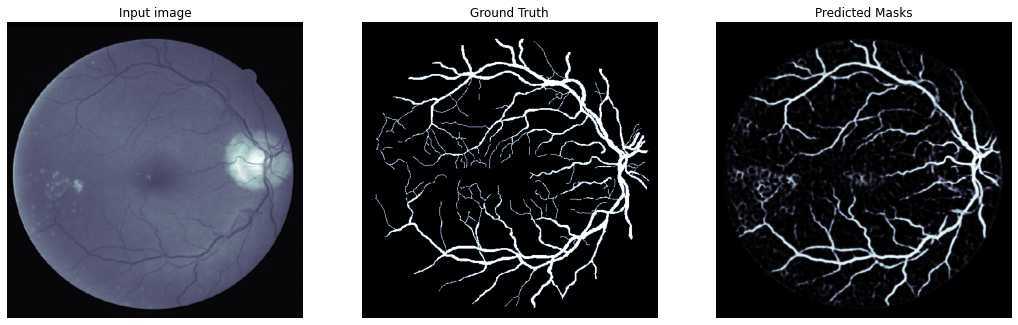

In [105]:
display_sample(y_pred, index = 18)

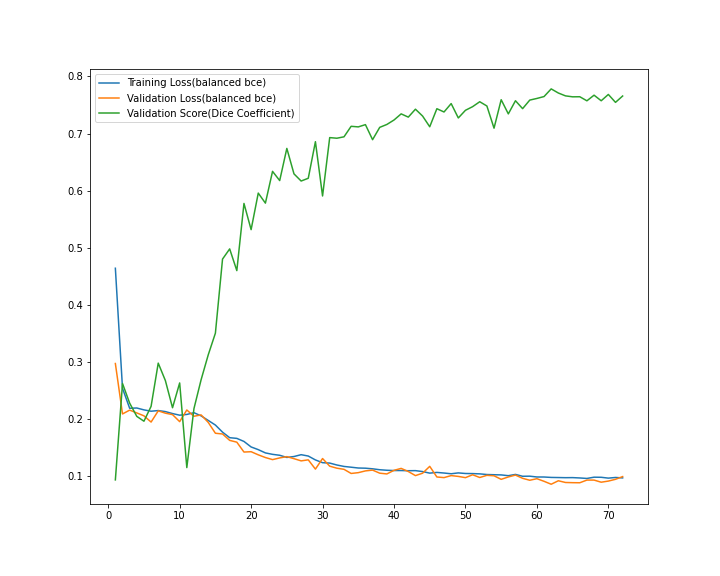

In [106]:
show_learning_plot('/content/drive/MyDrive/DRIVE project/performances record1/balanced BCE/plot.png')

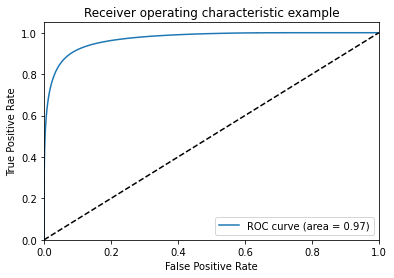

In [107]:
threshold = plot_roc(image_list = y_pred)

In [108]:
print_results(y_pred, threshold)

The area under curve is :0.9704413502421103 , the f1 score is: 0.652732511454348, IoU is: 0.4844862041159766 and the accuracy is: 0.915863037109375


## Dice Loss

In [67]:
model = load_model('/content/drive/MyDrive/DRIVE project/performances record1/Dice Loss/unet_160epoch.pt')
y_pred = make_predictions(model)

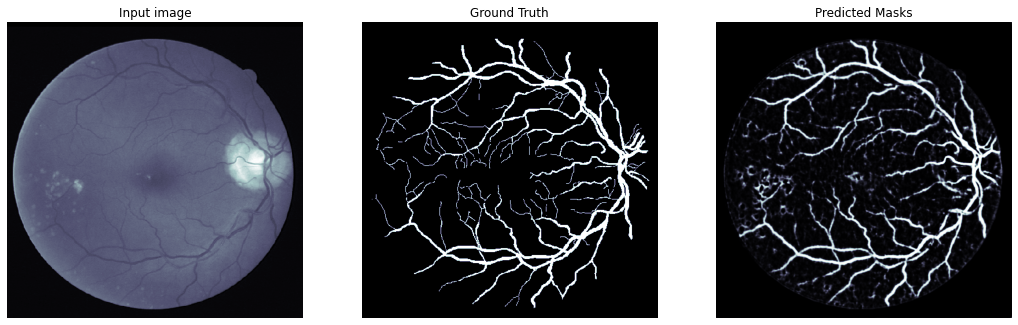

In [68]:
display_sample(y_pred, index = 18)

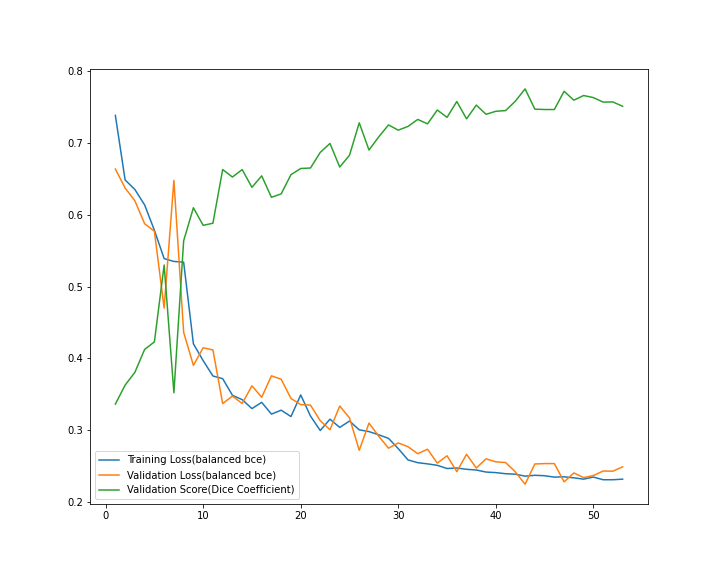

In [69]:
show_learning_plot('/content/drive/MyDrive/DRIVE project/performances record1/Dice Loss/plot.png')

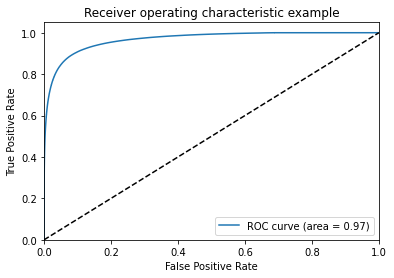

In [70]:
threshold = plot_roc(image_list = y_pred)

In [71]:
print_results(y_pred, threshold)

The area under curve is :0.9669488803251309 , the f1 score is: 0.6464913241980333, IoU is: 0.4776410641143331 and the accuracy is: 0.9144754409790039


## Focal Loss

In [72]:
model = load_model('/content/drive/MyDrive/DRIVE project/performances record1/Focal Loss/unet_160epoch.pt')
y_pred = make_predictions(model)

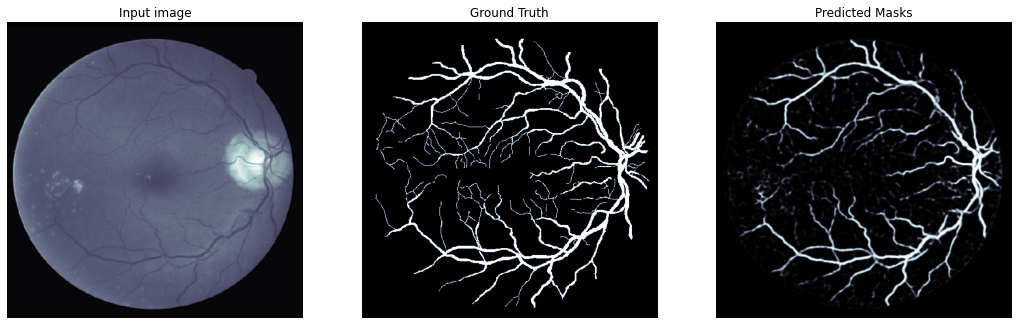

In [73]:
display_sample(y_pred, index = 18)

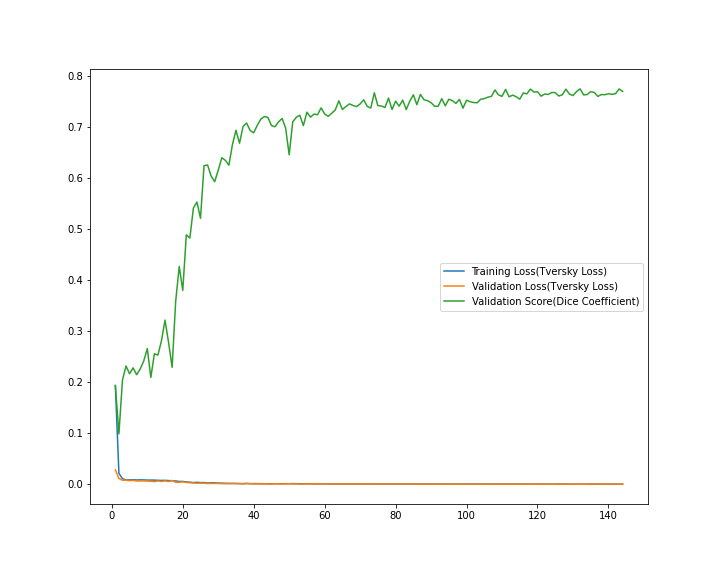

In [74]:
show_learning_plot('/content/drive/MyDrive/DRIVE project/performances record1/Focal Loss/plot.png')

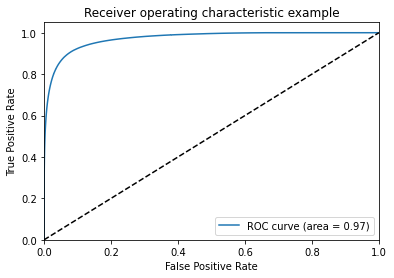

In [75]:
threshold = plot_roc(image_list = y_pred)

In [76]:
print_results(y_pred, threshold)

The area under curve is :0.9721114985771425 , the f1 score is: 0.660605225041915, IoU is: 0.49321173816180375 and the accuracy is: 0.9183002471923828


## Tversky Loss

In [77]:
model = load_model('/content/drive/MyDrive/DRIVE project/performances record1/Tversky/unet_160epoch.pt')
y_pred = make_predictions(model)

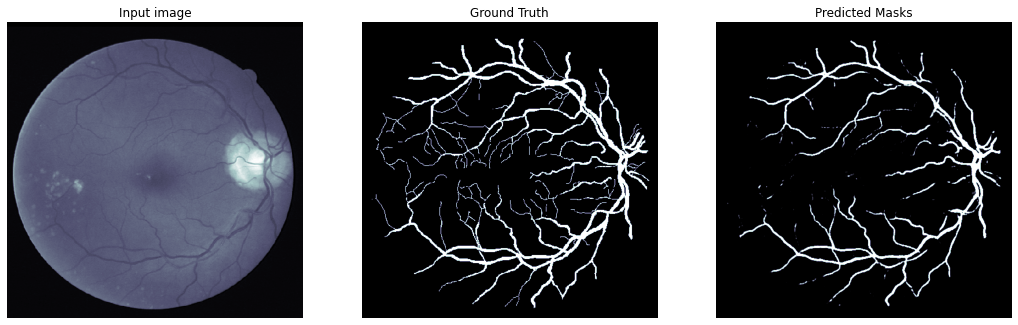

In [78]:
display_sample(y_pred, index = 18)

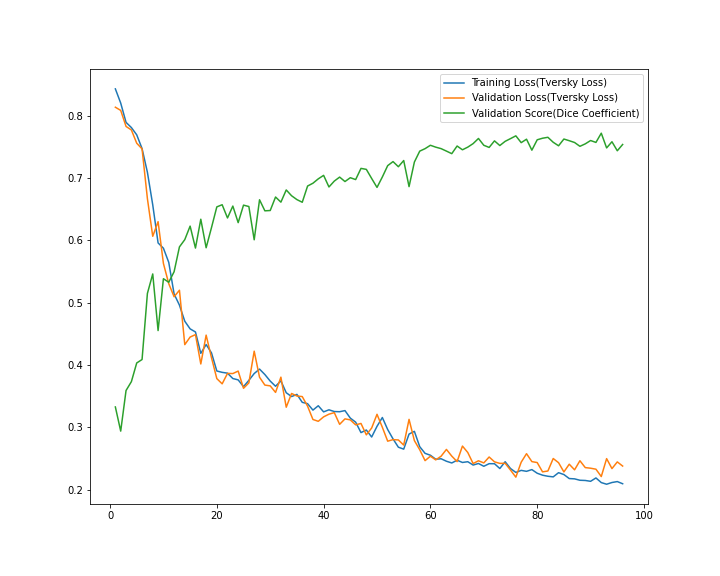

In [79]:
show_learning_plot('/content/drive/MyDrive/DRIVE project/performances record1/Tversky/plot.png')

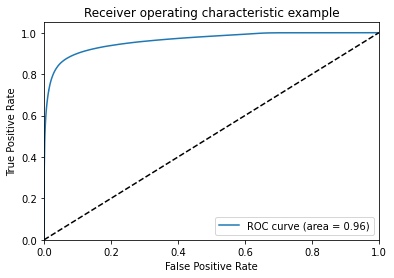

In [80]:
threshold = plot_roc(image_list = y_pred)

In [82]:
print_results(y_pred, .52)

The area under curve is :0.9614341291259836 , the f1 score is: 0.7573347422424614, IoU is: 0.6094438848392012 and the accuracy is: 0.9625055313110351
